In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from glob import glob

# Config
DATA_DIR = "../DataSet/Smaller Velocity Dataset/"
MODEL_SAVE_PATH = "../Models/velocity_regressor_split.pth"
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

# Dataset definition
class VelocityDataset(Dataset):
    def __init__(self, images, velocities, transform=None):
        # Convert from channels-first to channels-last if needed
        if images.ndim == 4 and images.shape[1] == 3:
            images = np.transpose(images, (0, 2, 3, 1))

        # Scale from [0,1] to [0,255] if normalized
        if images.max() <= 1.0:
            images = (images * 255).astype(np.uint8)

        self.images = images
        self.velocities = velocities
        self.transform = transform

    def __len__(self):
        return len(self.velocities)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        velocity = self.velocities[idx]

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor([velocity], dtype=torch.float32)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load all image and velocity files
image_files = sorted(glob(os.path.join(DATA_DIR, "*_images_Smaller.npy")))
velocity_files = sorted(glob(os.path.join(DATA_DIR, "*_velocity_Smaller.npy")))

all_images = []
all_velocities = []

for img_file, vel_file in zip(image_files, velocity_files):
    imgs = np.load(img_file)
    vels = np.load(vel_file)
    all_images.append(imgs)
    all_velocities.append(vels)

images = np.concatenate(all_images, axis=0)
velocities = np.concatenate(all_velocities, axis=0)

# Train/validation/test split
X_temp, X_test, y_temp, y_test = train_test_split(
    images, velocities, test_size=0.1, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42
)
# This results in roughly 80% train, 10% val, 10% test

# Create datasets and data loaders
train_dataset = VelocityDataset(X_train, y_train, transform)
val_dataset = VelocityDataset(X_val, y_val, transform)
test_dataset = VelocityDataset(X_test, y_test, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model definition
class VelocityRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        base.fc = nn.Linear(base.fc.in_features, 1)
        self.model = base

    def forward(self, x):
        return self.model(x)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VelocityRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")


c:\Users\pravi\anaconda3\envs\ACS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pravi\anaconda3\envs\ACS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Train Loss: 3.0064 - Val Loss: 0.7884
Epoch 2/10 - Train Loss: 0.6911 - Val Loss: 0.4753
Epoch 3/10 - Train Loss: 0.4638 - Val Loss: 0.4205
Epoch 4/10 - Train Loss: 0.3368 - Val Loss: 0.3606
Epoch 5/10 - Train Loss: 0.2753 - Val Loss: 0.2916
Epoch 6/10 - Train Loss: 0.2180 - Val Loss: 0.2814
Epoch 7/10 - Train Loss: 0.1849 - Val Loss: 0.2767
Epoch 8/10 - Train Loss: 0.1586 - Val Loss: 0.2939
Epoch 9/10 - Train Loss: 0.1391 - Val Loss: 0.2854
Epoch 10/10 - Train Loss: 0.1197 - Val Loss: 0.1998
✅ Model saved to ../Models/velocity_regressor_split.pth


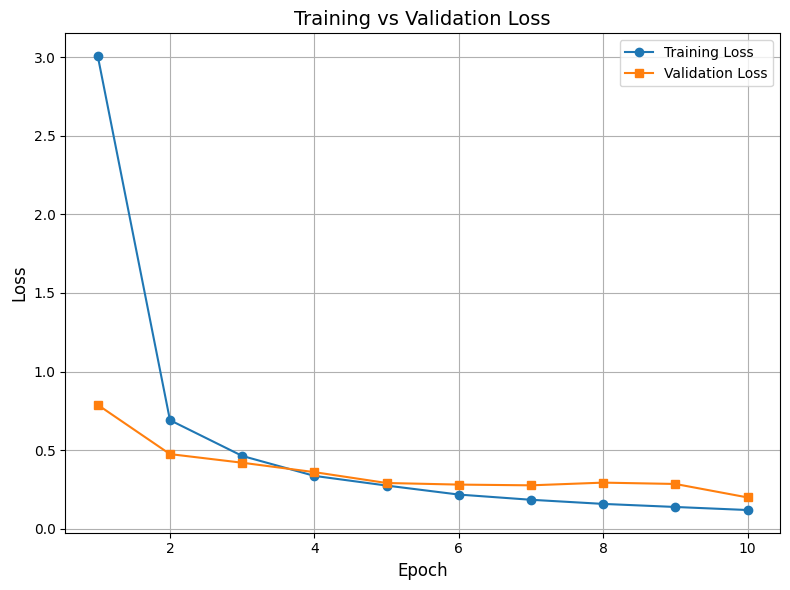

In [1]:
# %%
import matplotlib.pyplot as plt

# Training and validation losses from your log
train_loss = [3.0064, 0.6911, 0.4638, 0.3368, 0.2753, 0.2180, 0.1849, 0.1586, 0.1391, 0.1197]
val_loss   = [0.7884, 0.4753, 0.4205, 0.3606, 0.2916, 0.2814, 0.2767, 0.2939, 0.2854, 0.1998]

epochs = range(1, len(train_loss) + 1)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='s', label='Validation Loss')

# Labels, title, legend
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
